In [1]:
import pandas as pd
import numpy as np
import scipy as sc


import warnings 
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
%pylab inline

import datetime
import dateutil.relativedelta

import urllib

Populating the interactive namespace from numpy and matplotlib


In [2]:
Liabilities = ['DataDate', 'company','Sector',
                  'STD', 'LTD', 'other_liabilities',
                  'acc_payable','int_exp', 'liabilities_total']

Equity = ['DataDate', 'GVKey','Iid','Sector',
             'equity', 'Retained Earnings', 'stockholders_equity',
             'tangible_equity','book_value_per_share', 
             'Invested_capital', 'preference_stock' ]

Assets = ['DataDate', 'GVKey','Iid','Sector',
             'cur_assets', 'total_assets','cash', 
             'intangible_assets', 'inventories', 'acc_receivables']

PL = ['DataDate', 'GVKey','Iid','Sector',
         'sales', 'COGS', 'amort','Other_exp', 'ebit', 
         'interests_paid_net','tax', 'deferred_taxes', 
         'deferred_taxes_fed','deferred_taxes_foreign', 'income_taxes' ]

CF = ['DataDate', 'GVKey','Iid','Sector',
         'capex', 'dividends', 'op_act_net_CF', 
         'op_inc_after_dep', 'op_in_before_dep']

other = ['DataDate', 'GVKey','Iid','Sector',
            'employees', 'minority_interests', 
            'noncontrolling_interests', 'marketable_sec', 
            'working_cap', 'mii', 'Implied Option Expense']

Coef_tab = ['DataDate', 'GVKey','Iid','Sector',
               'EarningsYld', 'EpsGrowth1Yr', 'GrossMargin', 
               'OperatingMargin','PriceBook', 'ROA', 'ROE', 
               'SalesGrowth1Yr', 'SalesGrowth5Yr', 'SalesYld' ]

In [3]:
dd = pd.read_excel('New_Market_Data.xlsx')
dd.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
df = pd.read_excel('New_Fundamental_Data.xlsx')

## Проекция ликвидности 

### Краткосрочная ликвидность

$ Current Ratio = \frac{C.A.}{C.L.} $

$ Quick Ratio = \frac{C.A. - Inventories}{C.L.} $

$ Cash Ratio = \frac{Cash}{C.L.} $

### Долгосрочная ликвидность

$ICR = \frac{EBIT}{Interest expenses}$

$STDcoef = \frac{STD}{TD}$



In [5]:
wacc = pd.read_excel('wacc.xlsx')

# Считаем Доли долга и Доли собственного капитала
DE = pd.read_excel('DE.xlsx')
D = DE[['Date_1', 'gvkey', 'D']]
D = D.rename(columns = {'Date_1': 'Date'})
E = DE[['Date_2', 'gvkey.1', 'MkVal']]
E = E.rename(columns = {'Date_2': 'Date', 'gvkey.1': 'gvkey'})
DE = D.merge(E)
DE['dD'] = DE['D']/ (DE['MkVal'] + DE['D'])
DE['dE'] = DE['MkVal']/ (DE['MkVal'] + DE['D'])
DE = DE.rename(columns = {'Date': 'Year', 'gvkey': 'FIRM'})
DE = DE.assign(Year=DE.Year.dt.year)
DE.drop_duplicates(inplace=True)
DE.dropna(inplace=True)

naming = pd.read_excel('my_excel_file.xlsx')

list = []
for element in DE['FIRM']:
    if element in np.array(naming['GVKey']):
        list.append(1)
    else:
        list.append(0)

DE['indexing'] = list
DE = DE[DE.indexing == 1]

DE['company'] = 'new_name'
DE['label'] = 'new_label'
for element in np.array(naming['GVKey']):
    DE['company'][DE['FIRM'] == element] = np.array(naming['Company'][naming['GVKey'] == element])[0]
    DE['label'][DE['FIRM'] == element] = np.array(naming['Label'][naming['GVKey'] == element])[0]

wacc = pd.merge(wacc, DE, how = 'left')
wacc.drop_duplicates(inplace = True)
wacc['dD'] = wacc.groupby('company')['dD'].fillna(method='ffill')
wacc['dE'] = wacc.groupby('company')['dE'].fillna(method='ffill')

wacc['dD'] = wacc.groupby('company')['dD'].fillna(method='bfill')
wacc['dE'] = wacc.groupby('company')['dE'].fillna(method='bfill')

tax = df[['DataDate', 'label','income_taxes', 'ebit']]
tax.dropna(inplace = True)
tax['dtax'] = tax['income_taxes']/ tax['ebit']
tax = tax.rename(columns = {'DataDate' : 'Year'})
tax = tax.assign(Year=tax.Year.dt.year)
wacc = pd.merge(wacc, tax, how = 'left')
wacc['income_taxes'] = wacc.groupby('company')['income_taxes'].fillna(method='ffill')
wacc['income_taxes'] = wacc.groupby('company')['income_taxes'].fillna(method='bfill')

wacc = wacc[['Year', 'company', 'label','Re', 'dE', 'Rd', 'dD','dtax', 'beta', 'ERP', 'Rf', 'spread',   'D', 'MkVal' ]]

wacc['wacc'] = wacc['dD'] * wacc['Rd'] * (1-wacc['dtax'])  + wacc['dE'] * wacc['Re']

In [76]:
div = df[['DataDate', 'company', 'dividends', 'total_assets']]
div.dropna(inplace = True)
MK = dd[['DataDate', 'company', 'MK']]
MK['DataDate+1m'] = MK['DataDate']
MK['DataDate-1m'] = MK['DataDate']
MK['DataDate-1y'] = MK['DataDate']
MK['DataDate-1ym'] = MK['DataDate']
div['DataDate+1m'] = [element + dateutil.relativedelta.relativedelta(months=1) for element in div['DataDate']]
div['DataDate-1y'] = [element - dateutil.relativedelta.relativedelta(months=12) for element in div['DataDate']]
div['DataDate-1ym'] = [element - dateutil.relativedelta.relativedelta(months=11) for element in div['DataDate']]
div = div [['DataDate', 'DataDate+1m', 'DataDate-1y', 'DataDate-1ym', 'company', 'dividends', 'total_assets']]
tsr = pd.merge(div, MK[['DataDate', 'company', 'MK']], how = 'left', on = ['DataDate', 'company'])
tsr = pd.merge(tsr, MK[['DataDate+1m', 'company', 'MK']], how = 'left', on = ['DataDate+1m', 'company'])
tsr.MK_x = tsr.MK_x.fillna('abu')
tsr.MK_x = tsr.MK_x.where(tsr.MK_x != 'abu', tsr.MK_y)
tsr = tsr.drop(columns = ['MK_y'])
tsr = tsr.rename(columns = {'MK_x': 'MK'})

tsr = pd.merge(tsr, MK[['DataDate-1y', 'company', 'MK']], how = 'left', on = ['DataDate-1y', 'company'])
tsr = pd.merge(tsr, MK[['DataDate-1ym', 'company', 'MK']], how = 'left', on = ['DataDate-1ym', 'company'])
tsr = tsr.rename(columns = {'MK': 'MK_ym'})
tsr = tsr.rename(columns = {'MK_x': 'MK'})

tsr.MK_y = tsr.MK_y.fillna('abu')
tsr.MK_y = tsr.MK_y.where(tsr.MK_y != 'abu', tsr.MK_ym)
tsr = tsr.drop(columns = ['MK_ym'])
tsr.MK = tsr.MK.astype('float64')
tsr.MK_y = tsr.MK_y.astype('float64')

In [77]:
features_list = ['DataDate', 'company', 'label','current_ratio', 'icr', 'std_coef', 'ROCE', 'sales_growth',
                 'sales_yld', 'ebit/sales', 'gross_margin', 'eva', 'BV/MV','TSR']

features = df[['DataDate', 'label', 'company', 'Sector', 'cur_assets', 'STD', 'LTD', 'int_exp',
               'acc_payable', 'ebit', 'total_assets', 'SalesGrowth1Yr', 'SalesYld', 
              'sales', 'GrossMargin', 'income_taxes', 'Invested_capital', 'dividends' ]]

features = pd.merge(features, tsr[['DataDate', 'company','MK', 'MK_y']], how = 'left', on = ['DataDate', 'company'])
features['Year'] = pd.DatetimeIndex(features['DataDate']).year
features = pd.merge(features, wacc[['Year', 'company', 'wacc']], how = 'left', on = ['Year', 'company'])
features = features.drop_duplicates()

In [78]:
# ликвидность

features['current_ratio'] = features['cur_assets']/(features['STD']+ features['int_exp'] + features['acc_payable'] )

features['current_ratio'] = features['current_ratio'].where(features['current_ratio'] < 150, 150)

features['icr'] = features['ebit']/features['int_exp']
features['icr'] = features['icr'].where(features['icr'] != inf, 100)
features['icr'] = features['icr'].where(features['icr'] != -inf, 0)
features['icr'] = features['icr'].where(features['icr'] < 1500, 1500)

features['std_coef'] = features['STD']/ (features['LTD'] + features['STD'])

# эффективность

features['ROCE'] = features['ebit'] / (features['total_assets'] - (features['STD'] + features['int_exp'] + features['acc_payable']))

features['sales_growth'] = features['SalesGrowth1Yr']

features['sales_yld'] = features['SalesYld']

features['ebit/sales'] = features['ebit'] / features['sales']

features['gross_margin'] = features['GrossMargin']

#carefull, need to merge table wacc EVA = (ROIC - WACC) X Invested Capital
features['eva'] =  (((features['ebit'] - features['income_taxes']) / features['Invested_capital']) - features['wacc']) * features['Invested_capital']

#carefull, need to merge table tsr
features['BV/MV'] = features['total_assets'] / features['MK']
features['TSR'] = (features['dividends'] / features['MK_y']) + ((features['MK'] - features['MK_y'])/ features['MK_y'])
features = features[features_list]
features['BV/MV'] = features['BV/MV'].astype('float64')
features['TSR'] = features['TSR'].astype('float64')

In [91]:
ind = np.array([0])
for element in features.columns[3:]:
    outliers = np.array(features[features.groupby('company')[element].apply(lambda x: np.abs(x - x.median()) > \
                                                             (3 * 1.4826 * x.mad()))].any(axis=1).index)
    outliers = [index for index in outliers if index not in ind]
    ind =  np.concatenate((outliers, ind), axis=None)

features.drop(ind, inplace = True)

In [95]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
current_ratio,6891.0,39.488170,61.451383,0.321134,1.988123,4.244848,33.795522,150.000000
icr,6891.0,153.222712,420.005365,-638.439024,3.869906,9.695853,26.051889,1500.000000
std_coef,6494.0,0.171422,0.213582,0.000000,0.020447,0.096484,0.228692,1.000000
ROCE,6294.0,0.128151,0.100114,-0.763918,0.066336,0.115711,0.174069,1.084386
sales_growth,6832.0,9.242137,19.990837,-88.954885,0.627588,7.021318,14.807094,425.541619
sales_yld,6885.0,75.915396,92.490263,0.021049,27.223716,50.882598,90.280355,1412.639805
ebit/sales,6891.0,0.121295,2.082119,-102.702068,0.099697,0.161633,0.248959,0.755223
gross_margin,6793.0,37.024372,197.837093,-10425.357143,25.441696,39.086170,57.113188,99.683916
eva,6757.0,736.180866,2671.783328,-38140.306975,25.659697,243.894930,773.527032,40580.194666
BV/MV,5997.0,1.687304,2.680573,0.041123,0.489692,0.865952,1.650539,33.350194


In [ ]:
features['ISG'] = 0

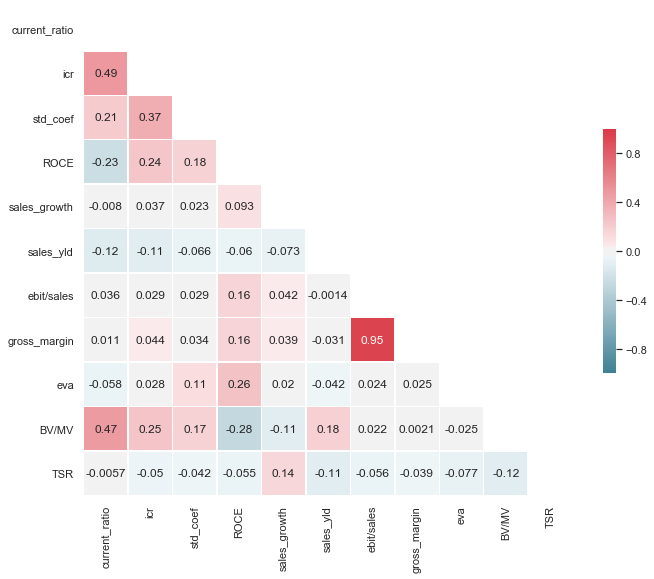

In [96]:
%config InlineBackend.figure_format = 'png' 
sns.set(style="white", palette = 'coolwarm')

# Compute the correlation matrix
corr = features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center = 0, vmin= -1, vmax = +1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

## Проекция эффективности

### Balance

GrossMargin 

OperatingMargin

ROA

ROE

SalesGrowth1Yr

SalesGrowth5Yr

SalesYld'

### Market

TSR = 

ROC - WACC = 

EVA = 

CVA = 

MCVA = 